# Fokker-Planck Equation II: Diffusion

This notebook looks into the integration of the diffusion term in the Fokker-Planck eqution, in the absence of Advection
Effectively, this means we will be simulating the dynamics of the equation

$$ \frac{\partial p(x, t)}{\partial t} = -D \frac{\partial^2 p(x, t)}{\partial x^2} $$

In this case, the method of solution is somewhat more complicated, as for stability we need to implement a semi-implicit scheme, in this case known as the *Crank-Nicolson* method.

In this case, for an initial distribution that is Gaussian, we should see that the distribution will spread out, and its variance should increase linearly in time $\sigma^2 \sim t$ (that is, until it interacts with a boundary condition), with proportionality related to the diffusion coefficient. We should still see and verify that normalization is preserved, and that the boundary conditions (in this case, periodic, open, and hard-wall) produce consistent results.

In [1]:
# To start, pull in the necessary imports
from pathlib import Path
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

proj_dir = Path().resolve().parents[0]
plot_dir = proj_dir / "figures" / "reports"

# the 1d integrator is contained in the Integrator module
from FPE import Integrator

# Dynamics parameters
D = 1.0
dt = 0.01
dx = 0.01
x_array = np.arange(-1, 1, dx)

# To start, initialize an integrator object
fpe = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="open")

# And we can, again, list the integrator attributes
fpe.__dict__.keys()

dict_keys(['D', 'dt', 'CFL', 'diffScheme', 'adScheme', 'BC', 'splitMethod', 'constDiff', 'output', 'sparseCalc', 'workAccumulator', 'workTracker', 'powerTracker', 'dx', 'N', 'prob', 'xArray', 'expImp', 'AMat', 'BMat', 'CMat', 'spaseCalc'])

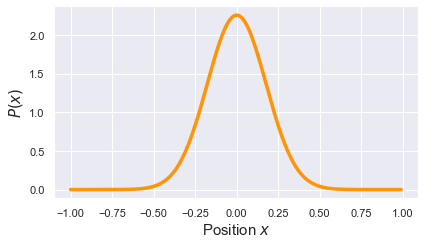

In [2]:
# Now, we can initialize the system with a Gsassian distribution using hthe build-in initializer
init_var = 1 / 32
fpe.initializeProbability(0, init_var)

# and plot the initial probably
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
ax.plot(fpe.xArray, fpe.prob, linewidth=3.5, color=sns.xkcd_rgb["tangerine"])
ax.set_xlabel(r"Position $x$", fontsize=15)
ax.set_ylabel(r"$P(x)$", fontsize=15)
plt.tight_layout()
plt.show()

In [3]:
# Beacuse we are working with diffusion-only, there is no CFL criterion, so we
# can just apply the diffusion algorithm to the initial distribution directly

# We initialized the system with open boundary conditions, so we should see the
# disitributions rpead out and pass through the boundaries, while the
# normalization will drop off in time
tot_time = 2.0
time = 0
counter = 0

time_tracker = [0]
density_tracker = [fpe.get_prob]

while time <= tot_time:
    fpe.diffusionUpdate()
    time += dt
    counter += 1
    if counter % 5 == 0:
        density_tracker.append(fpe.get_prob)
        time_tracker.append(time)


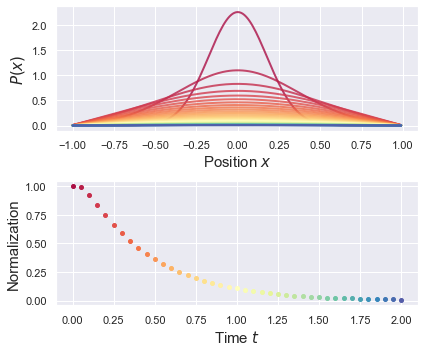

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.0))
Pal = sns.color_palette('Spectral', len(density_tracker))

for i, density in enumerate(density_tracker):
    ax[0].plot(fpe.xArray, density, color=Pal[i], linewidth=2.0, alpha=0.8)
    ax[1].plot(time_tracker[i], np.sum(density * fpe.dx), 'o', markersize=4, color=Pal[i])

ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Normalization", fontsize=15)
plt.tight_layout()
plt.show()



In [5]:
# Now, we can also look at hard-wall and periodic boundaries. In this case, we
# should see normalization preserved, and the system to equilibrate to a
# uniform distribution over the allowed domain

init_var = 1/64

fpe_periodic = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='periodic', output=False)
fpe_hard_wall = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='hard-wall', output=False)

fpe_periodic.initializeProbability(0, init_var)
fpe_hard_wall.initializeProbability(0, init_var)


In [6]:
# Now lets run the hard-wall scenario
fpe_hard_wall.initializeProbability(0, init_var)
fpe_periodic.initializeProbability(0, init_var)

total_time = 2.0
time = 0
counter = 0
density_tracker_hw = [fpe_hard_wall.get_prob]
density_tracker_per = [fpe_periodic.get_prob]
time_tracker = [time]

while time < total_time:
    fpe_hard_wall.diffusionUpdate()
    fpe_periodic.diffusionUpdate()
    counter += 1
    time += fpe_hard_wall.dt
    if counter % 5 == 0:
        density_tracker_hw.append(fpe_hard_wall.get_prob)
        density_tracker_per.append(fpe_periodic.get_prob)
        time_tracker.append(time)


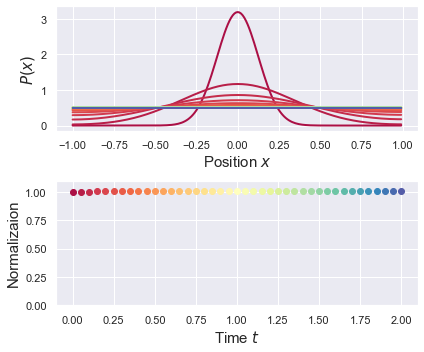

In [7]:
# First lets look at the hard-wall results
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
Pal = sns.color_palette("Spectral", len(density_tracker_hw))

for i, density in enumerate(density_tracker_hw):
    ax[0].plot(x_array, density, linewidth=2.0, color=Pal[i])
    ax[1].plot(time_tracker[i], np.sum(density * dx), 'o', markersize=6, color=Pal[i])

ax[1].set_ylim([0, 1.1])
ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Normalizaion", fontsize=15)
plt.tight_layout()
plt.show()



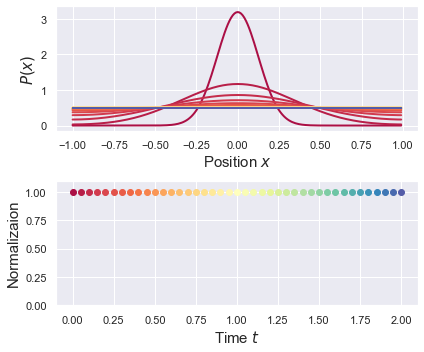

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
Pal = sns.color_palette("Spectral", len(density_tracker_per))

for i, density in enumerate(density_tracker_per):
    ax[0].plot(x_array, density, linewidth=2.0, color=Pal[i])
    ax[1].plot(time_tracker[i], np.sum(density * dx), 'o', markersize=6, color=Pal[i])

ax[1].set_ylim([0, 1.1])
ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[1].set_ylabel(r"Normalizaion", fontsize=15)
plt.tight_layout()
plt.show()



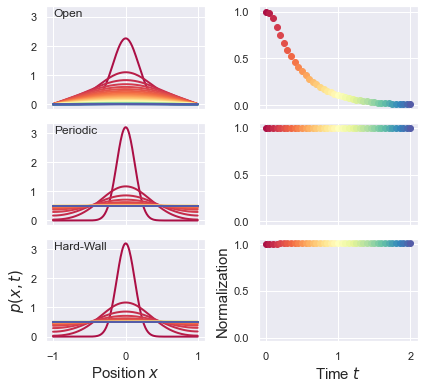

In [16]:
# And then we can make a combined subplot that shows all of this
fig, ax = plt.subplots(3, 2, figsize=(6, 5.5), sharex='col', sharey='col')

for i, (d_op, d_per, d_hw) in enumerate(zip(density_tracker, density_tracker_per, density_tracker_hw)):
    ax[0, 0].plot(x_array, d_op, linewidth=2.0, color=Pal[i])
    ax[1, 0].plot(x_array, d_per, linewidth=2.0, color=Pal[i])
    ax[2, 0].plot(x_array, d_hw, linewidth=2.0, color=Pal[i])

    ax[0, 1].plot(time_tracker[i], np.sum(d_op * dx), 'o', markersize=6, color=Pal[i])
    ax[1, 1].plot(time_tracker[i], np.sum(d_per * dx), 'o', markersize=6, color=Pal[i])
    ax[2, 1].plot(time_tracker[i], np.sum(d_hw * dx), 'o', markersize=6, color=Pal[i])

ax[2, 0].set_xlabel(r"Position $x$", fontsize=15)
ax[2, 1].set_xlabel(r"Time $t$", fontsize=15)

ax[2, 0].set_ylabel(r"$p(x, t)$", fontsize=15)
ax[2, 1].set_ylabel(r"Normalization", fontsize=15)

ax[0, 0].annotate(r"Open", xy=(0.05,0.90), xycoords="axes fraction", fontsize=12)
ax[1, 0].annotate(r"Periodic", xy=(0.05,0.90), xycoords="axes fraction", fontsize=12)
ax[2, 0].annotate(r"Hard-Wall", xy=(0.05,0.90), xycoords="axes fraction", fontsize=12)

plt.tight_layout()
plt.savefig(plot_dir / "diffusion_relax_sample.pdf", format="pdf")
plt.show()


So, it appears in all cases the distribution is evolving in time as we would expect, and the boundary conditions are all behaving as well. Now we want to test two things. First, the periodic and hard-wall situations look very similar in the simulations above, which is due to to symmetric of the initial distribution (it is centered about the middle of the domain). So, we can start to see differences in their behaviour if we initialize a system in a distribution that is not centered at $x = 0$. Here, the periodic system should equilibrate faster, as it will be able to diffuse over the periodic boundary, while the hard wall system can only reach tha far side of the domain by traversing the interior.  We can quantify this by tracking the deviation of the distrubution fromuniform, by calculating

$$ \text{MSD} = \frac{1}{N}\sum_{i=0}^{N-1} \left( p_i - \langle p_i\rangle \right)^2 $$

which, for a uniform distribution will be zero, and and increasing function of the departure from uniform. Thus, we should see that, for a periodic boundary condition, the measure *should* decay to zero faster that for hard-wall boundary conditions.

In [32]:
init_var = 1/128
fpe_periodic.initializeProbability(-0.5, init_var)
fpe_hard_wall.initializeProbability(-0.5, init_var)

total_time = 2.0
time = 0
counter = 0
time_tracker = [0]
density_tracker_hw = [fpe_hard_wall.get_prob]
density_tracker_per = [fpe_periodic.get_prob]

while time < total_time:
    fpe_periodic.diffusionUpdate()
    fpe_hard_wall.diffusionUpdate()
    time += fpe_periodic.dt
    counter += 1
    if counter % 5 == 0:
        density_tracker_hw.append(fpe_hard_wall.get_prob)
        density_tracker_per.append(fpe_periodic.get_prob)
        time_tracker.append(time)


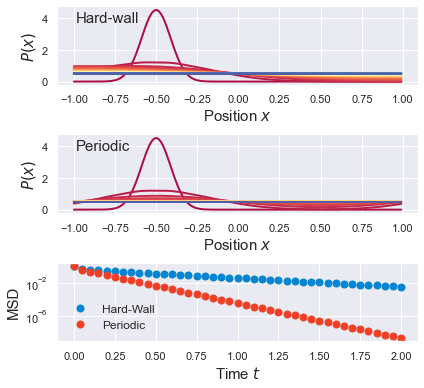

In [33]:
fig, ax = plt.subplots(3, 1, figsize=(6, 5.5))
Pal = sns.color_palette("Spectral", len(density_tracker_hw))

msd_hw = []
msd_per = []

for i, (dens_hw, dens_per) in enumerate(zip(density_tracker_hw, density_tracker_per)):
    ax[0].plot(x_array, dens_hw, color=Pal[i], linewidth=2.0)
    ax[1].plot(x_array, dens_per, color=Pal[i], linewidth=2.0)

    msd_hw.append(np.std(dens_hw))
    msd_per.append(np.std(dens_per))

ax[2].plot(time_tracker, msd_hw, 'o', color=sns.xkcd_rgb["cerulean"], markersize=7, label="Hard-Wall")
ax[2].plot(time_tracker, msd_per, 'o', color=sns.xkcd_rgb["tomato"], markersize=7, label="Periodic")

ax[2].set_yscale('log')
ax[2].set_xlabel(r"Time $t$", fontsize=15)
ax[2].set_ylabel(r"MSD", fontsize=15)
ax[1].set_xlabel(r"Position $x$", fontsize=15)
ax[1].set_ylabel(r"$P(x)$", fontsize=15)
ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)

ax[0].annotate(r"Hard-wall", xy=(0.05,0.8), xycoords="axes fraction", fontsize=15)
ax[1].annotate(r"Periodic", xy=(0.05,0.8), xycoords="axes fraction", fontsize=15)
ax[2].legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig(plot_dir / "diffusion_hw_periodic_relax.pdf", format="pdf")
plt.show()

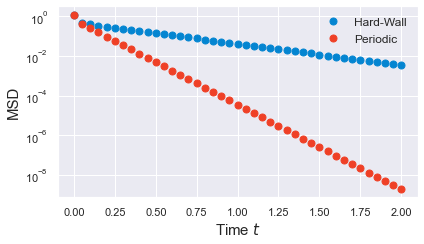

In [35]:
# And then just the last plot, in isolation
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette("Spectral", len(density_tracker_hw))

ax.plot(time_tracker, msd_hw, 'o', color=sns.xkcd_rgb["cerulean"], markersize=7, label="Hard-Wall")
ax.plot(time_tracker, msd_per, 'o', color=sns.xkcd_rgb["tomato"], markersize=7, label="Periodic")

ax.set_yscale('log')
ax.set_xlabel(r"Time $t$", fontsize=15)
ax.set_ylabel(r"MSD", fontsize=15)
ax.legend(fontsize=12, frameon=False)

plt.tight_layout()
plt.savefig(plot_dir / "diffusion_hw_periodic_relax_msd.pdf", format="pdf")
plt.show()


Here, you can see that the MSD of the periodic boundary conditions decays (on a log-y scale) at a faster rate than the hard-wall conditions, as we would expect.

Now, we want to look at the dynamics of the diffusion. We know that the variance of the distribution should get larger at a rate of 

$$ \sigma^2 = 2 D t $$

(so long as there is no interference from boundary conditions) So, if we track the variance over time for a system initialized on a large enough domain, we should be able to see this scaling relationship.

To test this, we initialize a thin Gaussian distribution on a much larger domain (which will make the calculation slower as the diffusion matric will be much larger) and then observe the variance of the time-evolving distribution

In [21]:
x_array_large = np.arange(-5, 5, dx)
init_var = 1/ 128

fpe_diff = Integrator.FPE_Integrator_1D(1, dt, dx, x_array_large, boundaryCond='open')
fpe_diff_2 = Integrator.FPE_Integrator_1D(2, dt, dx, x_array_large, boundaryCond='open')
fpe_diff_4 = Integrator.FPE_Integrator_1D(4, dt, dx, x_array_large, boundaryCond='open')

In [22]:
fpe_diff.initializeProbability(0, init_var)
fpe_diff_2.initializeProbability(0, init_var)
fpe_diff_4.initializeProbability(0, init_var)

total_time = 2.0
time = 0
counter += 1

time_tracker = [time]
density_tracker_diff = [fpe_diff.get_prob]
density_tracker_diff_2 = [fpe_diff_2.get_prob]
density_tracker_diff_4 = [fpe_diff_4.get_prob]

while time <= total_time:
    fpe_diff.diffusionUpdate()
    fpe_diff_2.diffusionUpdate()
    fpe_diff_4.diffusionUpdate()

    time += fpe_diff.dt
    counter += 1

    if counter % 1 == 0:
        density_tracker_diff.append(fpe_diff.get_prob)
        density_tracker_diff_2.append(fpe_diff_2.get_prob)
        density_tracker_diff_4.append(fpe_diff_4.get_prob)
        time_tracker.append(time)



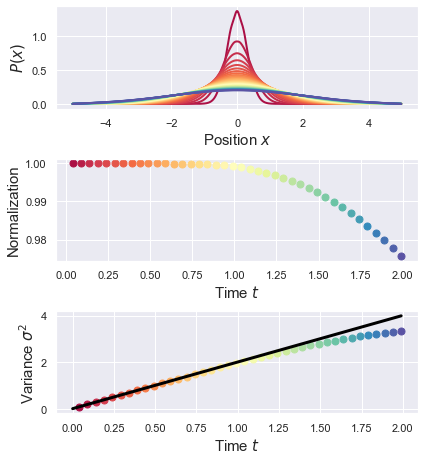

In [29]:
def _get_variance(density, x_vals):
    dx = x_vals[1] - x_vals[0]
    mean = np.sum(x_vals * density * dx)
    var = np.sum(((x_vals - mean) ** 2) * density * dx)
    return var

theory_time = np.arange(0, 2, 0.01)
theory_var = init_var * 1 + (2 * D  * theory_time)

fig, ax = plt.subplots(3, 1, figsize=(6, 6.5))

Pal = sns.color_palette("Spectral", len(density_tracker_diff))

for i, density in enumerate(density_tracker_diff):
    if i % 5 == 4:
        ax[0].plot(x_array_large, density, color=Pal[i], linewidth=2.0)
        ax[1].plot(time_tracker[i], np.sum(density * fpe_diff.dx), 'o', markersize=7, color=Pal[i])
        ax[2].plot(time_tracker[i], _get_variance(density, fpe_diff.xArray), 'o', markersize=7, color=Pal[i])
ax[2].plot(theory_time, theory_var, color=sns.xkcd_rgb["black"], linewidth=3.0)

ax[0].set_xlabel(r"Position $x$", fontsize=15)
ax[1].set_xlabel(r"Time $t$", fontsize=15)
ax[2].set_xlabel(r"Time $t$", fontsize=15)
ax[2].set_ylabel(r"Variance $\sigma^2$", fontsize=15)
ax[1].set_ylabel(r"Normalization", fontsize=15)
ax[0].set_ylabel(r"$P(x)$", fontsize=15)
plt.tight_layout()
plt.savefig(plot_dir / "diffusion_relation_sample.pdf", format="pdf")

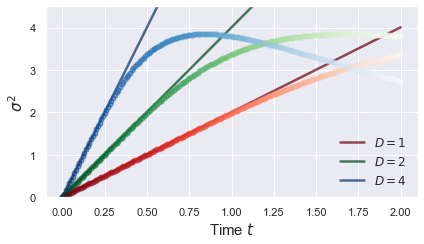

In [30]:
# And we can also plot the linear trends for the alternate diffusion coefficients
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal_1 = sns.color_palette("Reds_r", len(density_tracker_diff))
Pal_2 = sns.color_palette("Greens_r", len(density_tracker_diff))
Pal_4 = sns.color_palette("Blues_r", len(density_tracker_diff))

ax.plot(time_tracker, init_var + (2 * np.array(time_tracker)), linewidth=2.5, color=Pal_1[0], label=r"$D=1$", alpha=0.7)
ax.plot(time_tracker, init_var + (4 * np.array(time_tracker)), linewidth=2.5, color=Pal_2[0], label=r"$D=2$", alpha=0.7)
ax.plot(time_tracker, init_var + (8 * np.array(time_tracker)), linewidth=2.5, color=Pal_4[0], label=r"$D=4$", alpha=0.7)

for i, (d1, d2, d4) in enumerate(zip(density_tracker_diff, density_tracker_diff_2, density_tracker_diff_4)):
    ax.plot(time_tracker[i], _get_variance(d1, x_array_large), 'o', markersize=5, color=Pal_1[i], alpha=0.5)
    ax.plot(time_tracker[i], _get_variance(d2, x_array_large), 'o', markersize=5, color=Pal_2[i], alpha=0.5)
    ax.plot(time_tracker[i], _get_variance(d4, x_array_large), 'o', markersize=5, color=Pal_4[i], alpha=0.5)

ax.set_ylim([0, 4.5])
ax.legend(fontsize=12, frameon=False)
ax.set_xlabel(r"Time $t$", fontsize=15)
ax.set_ylabel(r"$\sigma^2$", fontsize=15)
plt.tight_layout()
plt.savefig(plot_dir / "diffusion_relation_compare.pdf", format="pdf")
plt.show()

In [78]:
len(time_tracker)

201

In [79]:
# In fact, we can fit the first ~1/2 of the variance data to a line to see what
# the confidence in the slope parameter is
variance_trend = [_get_variance(dens, x_array_large) for dens in density_tracker_diff]
variance_trend_2 = [_get_variance(dens, x_array_large) for dens in density_tracker_diff_2]
variance_trend_4 = [_get_variance(dens, x_array_large) for dens in density_tracker_diff_4]

# X = sm.add_constant(time_tracker)
X = time_tracker
Y_1 = init_var + np.array(variance_trend)
Y_2 = init_var + np.array(variance_trend_2)
Y_4 = init_var + np.array(variance_trend_4)

model_1 = sm.OLS(Y_1[:len(Y_1) // (2 * 1)], X[:len(Y_1) // (2 * 1)])
model_2 = sm.OLS(Y_2[:len(Y_2) // (2 * 2)], X[:len(Y_2) // (2 * 2)])
model_4 = sm.OLS(Y_4[:len(Y_4) // (2 * 4)], X[:len(Y_4) // (2 * 4)])

result_1 = model_1.fit()
result_2 = model_2.fit()
result_4 = model_4.fit()

result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.312e+06
Date:                Wed, 29 Jun 2022   Prob (F-statistic):                   7.14e-206
Time:                        19:23:47   Log-Likelihood:                          318.21
No. Observations:                 100   AIC:                                     -634.4
Df Residuals:                      99   BIC:                                     -631.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0171      0.002   1145.265      0.000       2.014       2.021
==============================================================================
Omnibus:                       17.817   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.184
Skew:                          -1.099   Prob(JB):                     2.51e-05
Kurtosis:                       3.502   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.459e+05
Date:                Wed, 29 Jun 2022   Prob (F-statistic):                   1.30e-102
Time:                        19:21:06   Log-Likelihood:                          159.35
No. Observations:                  50   AIC:                                     -316.7
Df Residuals:                      49   BIC:                                     -314.8
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.0347      0.005    803.687      0.000       4.025       4.045
==============================================================================
Omnibus:                        9.951   Durbin-Watson:                   0.009
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                9.837
Skew:                          -1.065   Prob(JB):                      0.00731
Kurtosis:                       3.425   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
result_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          3.118e+05
Date:                Wed, 29 Jun 2022   Prob (F-statistic):                    6.96e-51
Time:                        19:21:09   Log-Likelihood:                          79.872
No. Observations:                  25   AIC:                                     -157.7
Df Residuals:                      24   BIC:                                     -156.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             8.0716      0.014    558.415      0.000       8.042       8.101
==============================================================================
Omnibus:                        5.596   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.061   Jarque-Bera (JB):                4.185
Skew:                          -0.994   Prob(JB):                        0.123
Kurtosis:                       3.252   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As required, th diffusive dynamics match the predicted relationship exactly over the first $\Delta t \sim 1$, before the distriubution begins permeating the bounray (indicated by the dropoff in normalization).  Importantly, however, this confirms that our dynamics matches expectations

Before moving on, we will briefly explore some of the aspects of the specifics of the diffusion integrator that are worth knowing. Sepecifically, because diffusion coefficients are often constant, the resulting set of matrix equations are alos constant, implying that---while matrix multipliction is always required at each step---it is possible to avoid explicit matrix inversion for each update step. This is because the mathiematical form of the $A$ and $B$ matrices are unchanged with each update, and therefore so are their inverses. So, while formally the update of probability in each diffusion step takes the form

$$ p_{t+1} = A^{-1}\cdot B\cdot p_t $$

we can simply store the result $C \equiv A^{-1}\cdot B$ in the first iteration, and update the proabability vector through matrix multiplication. Furthermore, even in advective scenarios, this is possible through the use of *operator splitting* methods (which will be discussed in a future notebook).

Next, because the $A$ and $B$ matrices are (aside from potential boundary terms) tri-diagonal, they are relatively sparse. As a reslt, many of the multiplication routines developed for sparse matrices can offer a significant improvement upon the naive implementation.  By default, the initialization of the integrator will time both naive and sparse-matrix implementations of a diffusion update, and uses whichever is fastest. Further, an initialization argument `constDiff`, which by default is set to `True`, and will test the analogous timing for the $C$ matrix update.



For matrix multiplication,  a naive and general purpose multiplication algorithm can be done relatively quickly with numpy, but in the case of a Crank-Nicolson integrator

In [14]:
# By default, for these parameters, sparse calculations are fastest.
fpe = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, constDiff=True)



Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion



In [15]:
fpe.sparseCalc, fpe.constDiff

(False, True)

In [16]:
fpe.initializeProbability(0, init_var)

%timeit fpe.diffusionUpdate()

11.9 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [24]:
# Now, we can remove the constant-diffrence flag
fpe_no_cd = Integrator.FPE_Integrator_1D(D, dt, dx, x_array, constDiff=False)



Initializing diffusion term integration matrix...

		Using Crank-Nicolson integration scheme...
		Initializing integration matrices for diffusion

		Sparse matrix methods preferred...


In [25]:
%timeit fpe_no_cd.diffusionUpdate()

90.2 µs ± 444 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [30]:
# Because the determination of sparse vs non-sparse matrices is made during the
# constructor initialization, so its not so obvious how to test the countercase
# However, we can just build dense versions of the update matrices, and then
# just time the internal logic of the diffusion update
AMat_dense = fpe_no_cd.AMat.todense()
BMat_dense = fpe_no_cd.BMat.todense()

def diffusionUpdate(
    prob: np.ndarray, BMat_dense: np.ndarray, AMat_dense: np.ndarray
):
    bVec = np.matmul(BMat_dense, prob).T
    return np.linalg.solve(AMat_dense, bVec)



In [31]:
# And for the constant diffusion coefficient situation...
%timeit diffusionUpdate(fpe_no_cd.get_prob, BMat_dense, AMat_dense)

422 µs ± 48.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


So, in summary, the naive way of implementing sparse-marix techniques to speed up the constant diffusion case is not a speedup at all, which is because the sparse operations between sparse matrices and vectors do not offer the same speedups. As a result, we have made the source code such that for a constant diffusion coefficient, dense matrix methods are always preferred. *Note that in all cases, the dense matrices will be less efficient on memory, which could become a concern in some cases, which we will address later when discussing multi-dimensional situations*